In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#Systematically save examples of images corresponding to every unique scientific objective in 1996.
sci_objs = []
dates = []
examplefpaths = []

#for year in range(1996, 2010):
for year in [2011]:  
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])

        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                #print(f.name)
                hdul = fits.open(f.path)
                header = hdul[0].header

                sci_objs.append(header['SCI_OBJ'])
                dates.append(header['DATE-BEG'])
                examplefpaths.append(f.path)

uniq_sci_objs = []
example_uniq_sci_objs = []
for i in range(len(sci_objs)):
    if sci_objs[i] not in uniq_sci_objs:
        #print(sci_objs[i])
        #print(dates[i])
        uniq_sci_objs.append(sci_objs[i])
        example_uniq_sci_objs.append(examplefpaths[i])

In [ ]:
print(len(uniq_sci_objs))
print(uniq_sci_objs)
#print(example_uniq_sci_objs)

1998-05-05T07:23:23.549Z
304
no


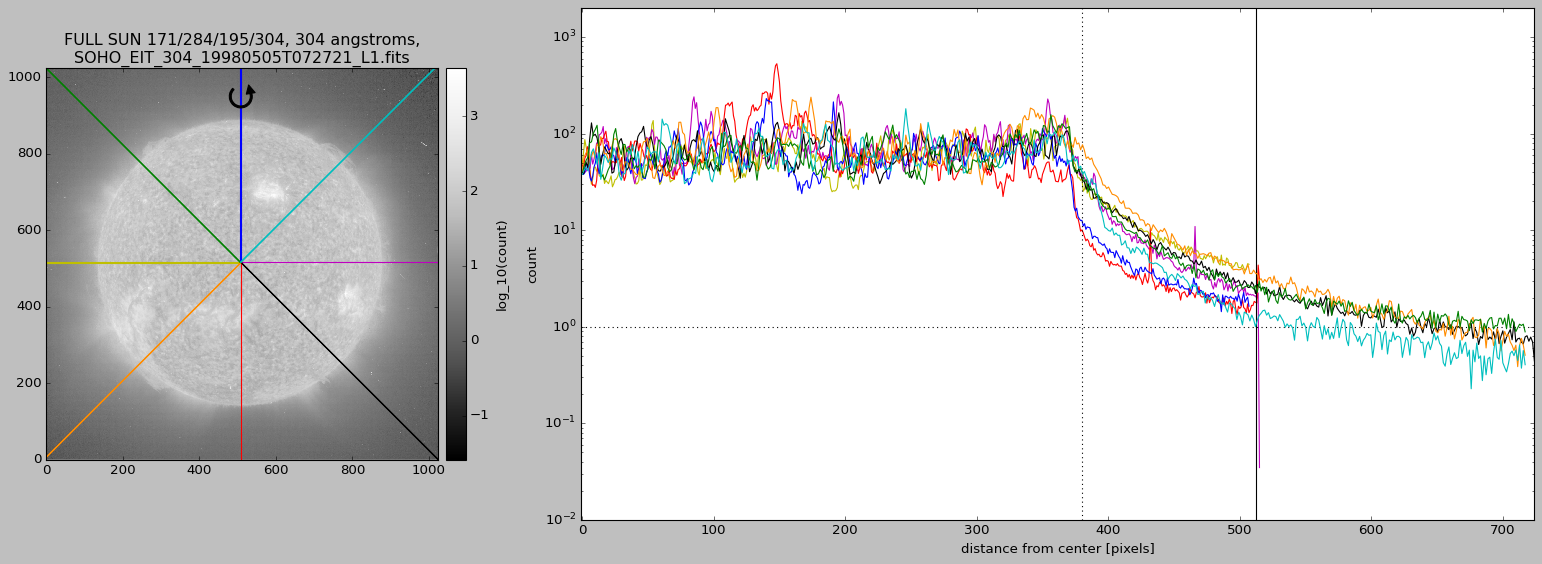

1998-05-05T13:27:14.069Z
195
no


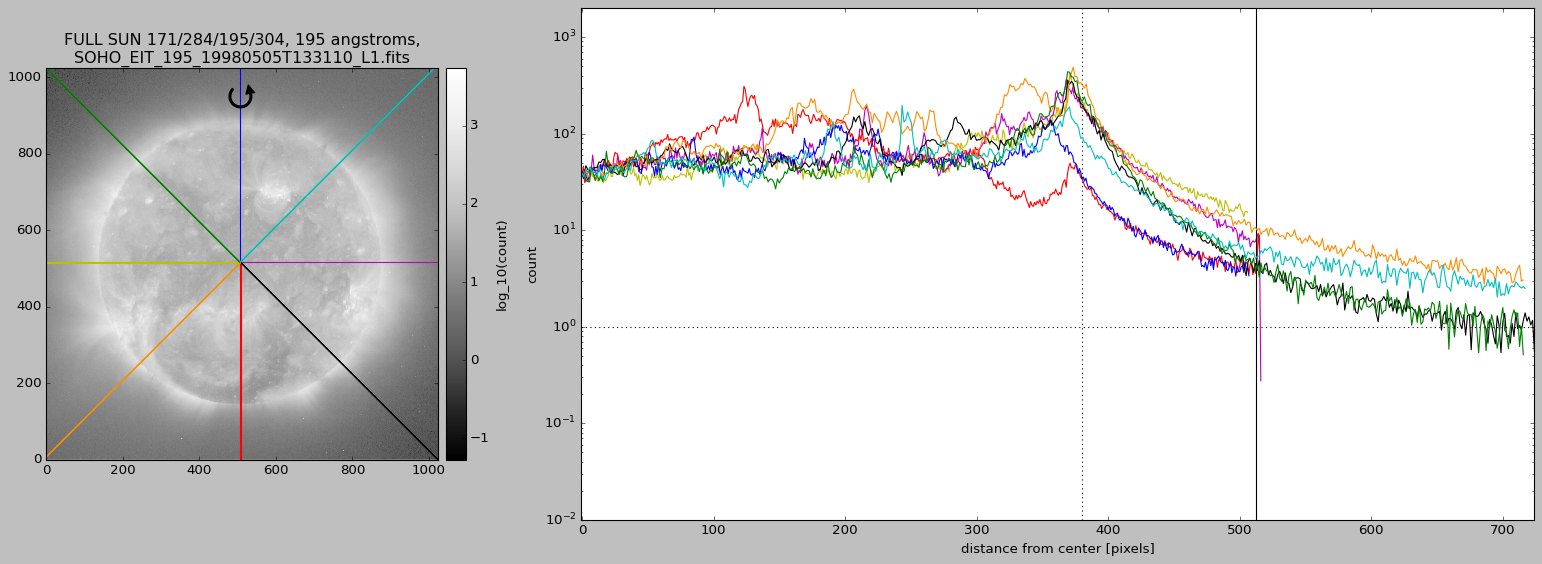

1998-05-05T19:27:52.765Z
284
yes


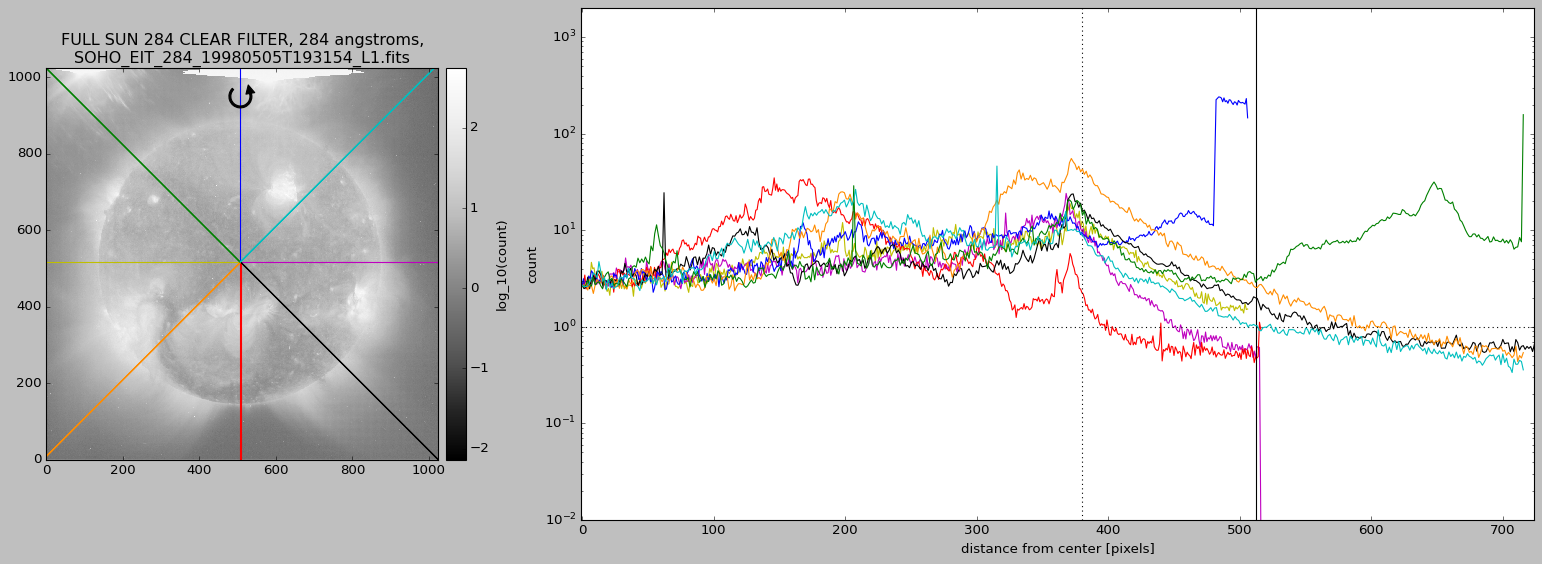

1998-05-05T01:14:30.936Z
195
no


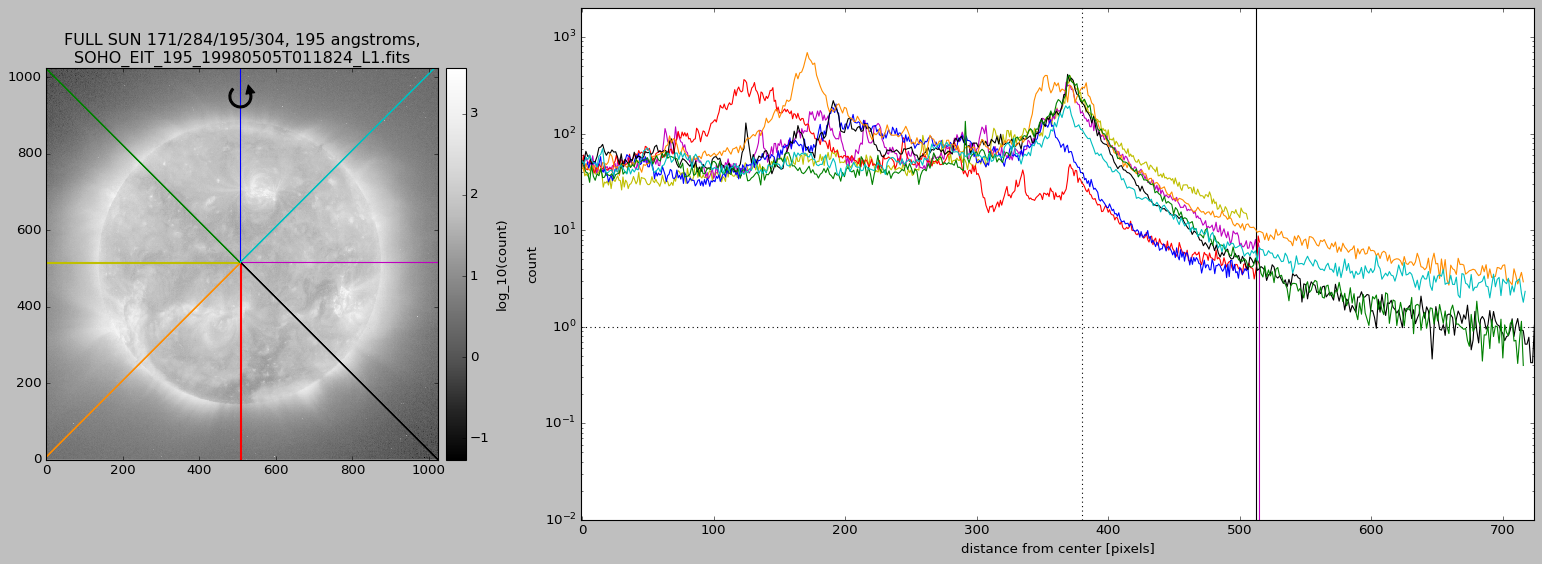

1998-05-05T13:33:16.834Z
304
yes


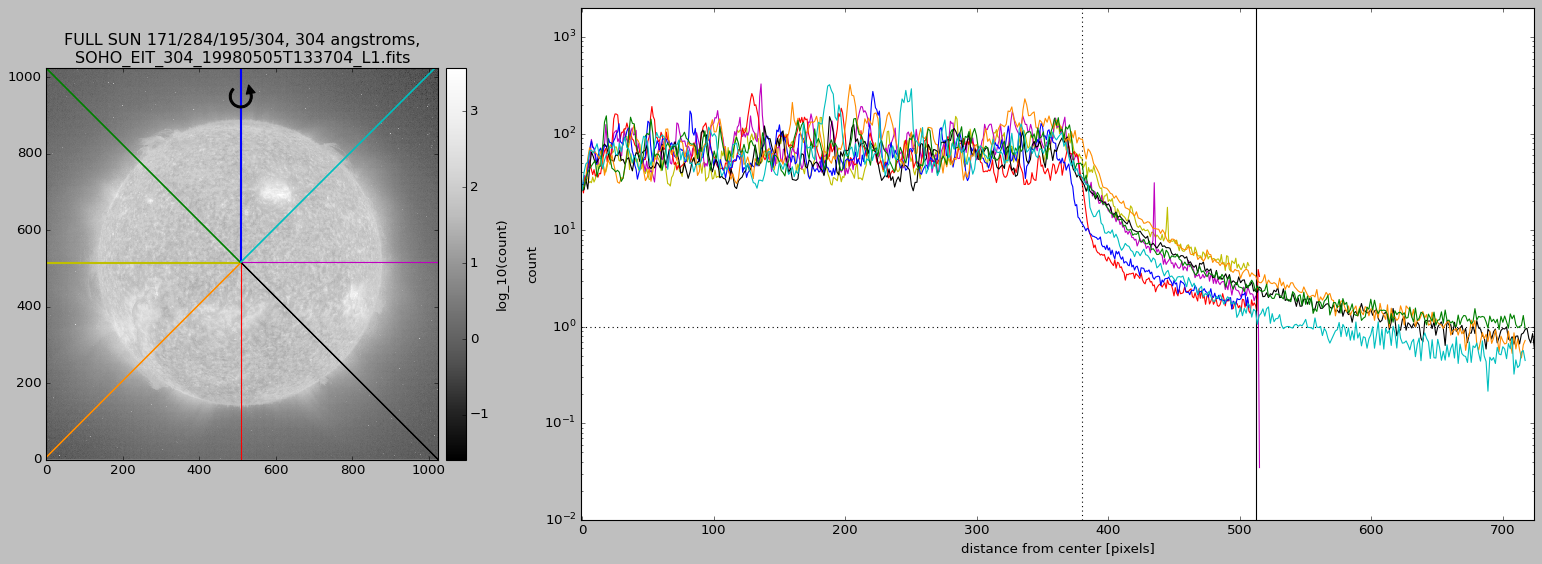

1998-05-05T19:40:16.892Z
304
yes


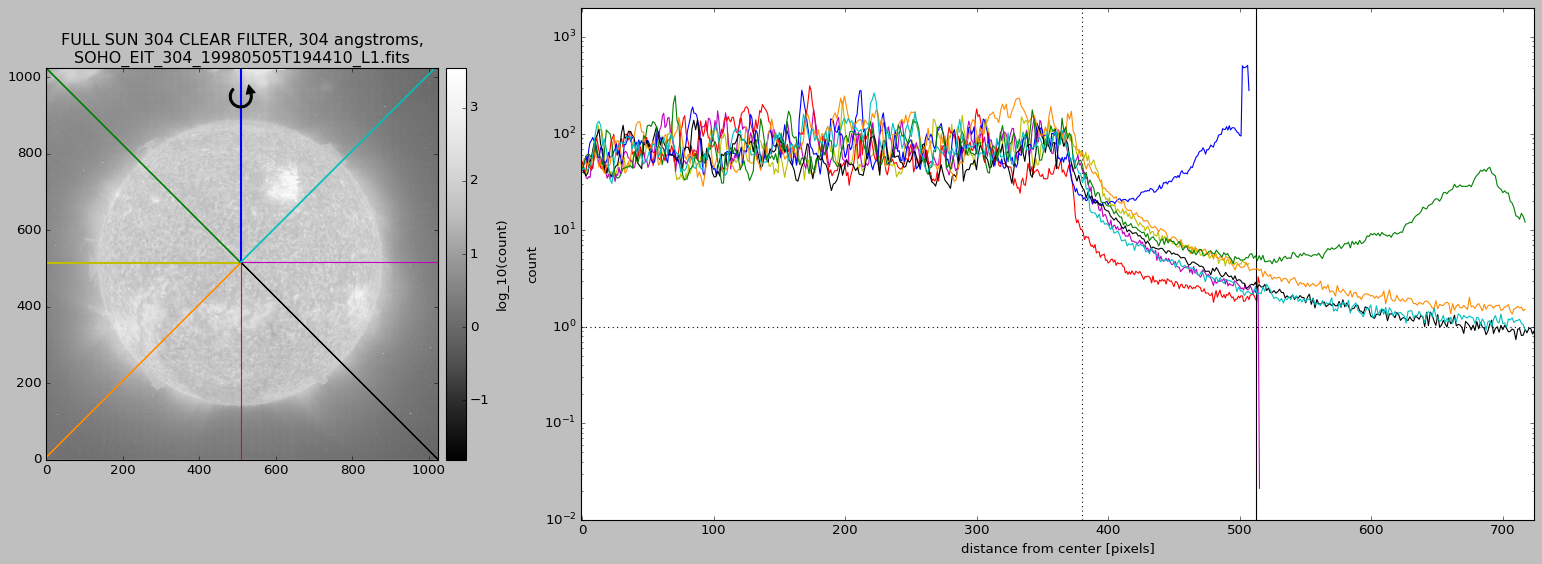

1998-05-05T13:19:03.275Z
284
yes


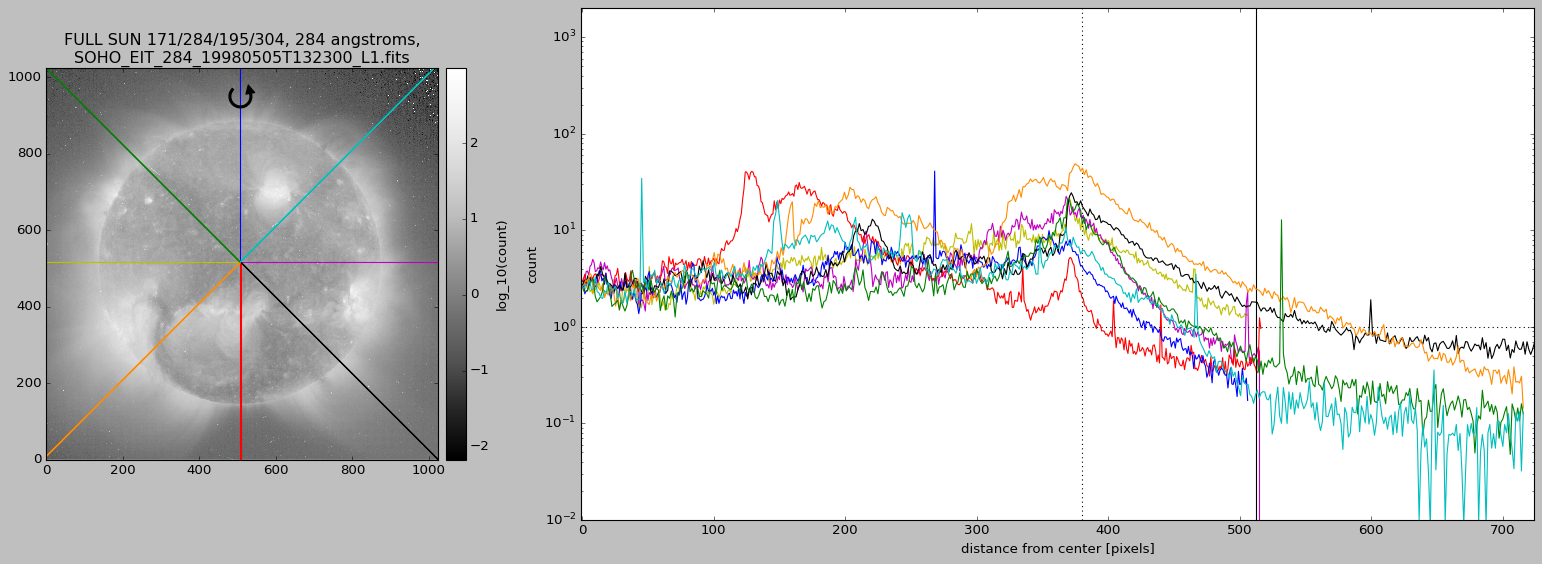

1998-05-05T13:13:20.399Z
171
no


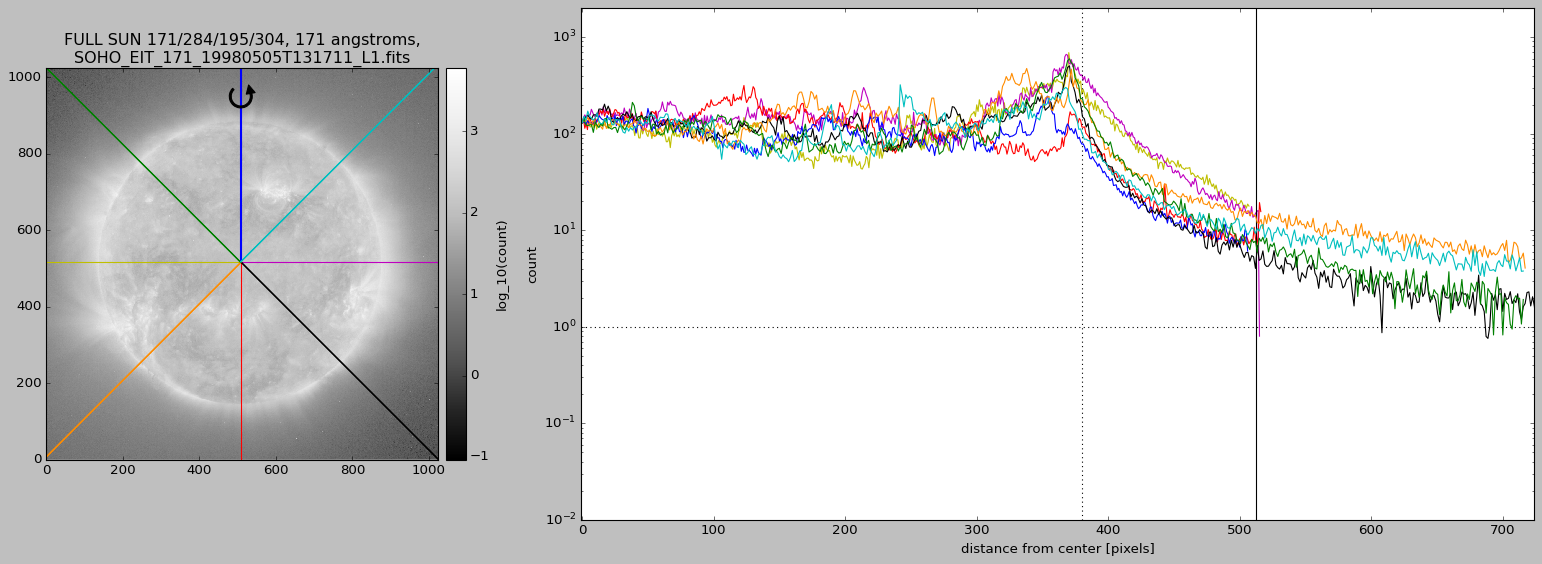

1998-05-05T01:20:24.033Z
304
yes


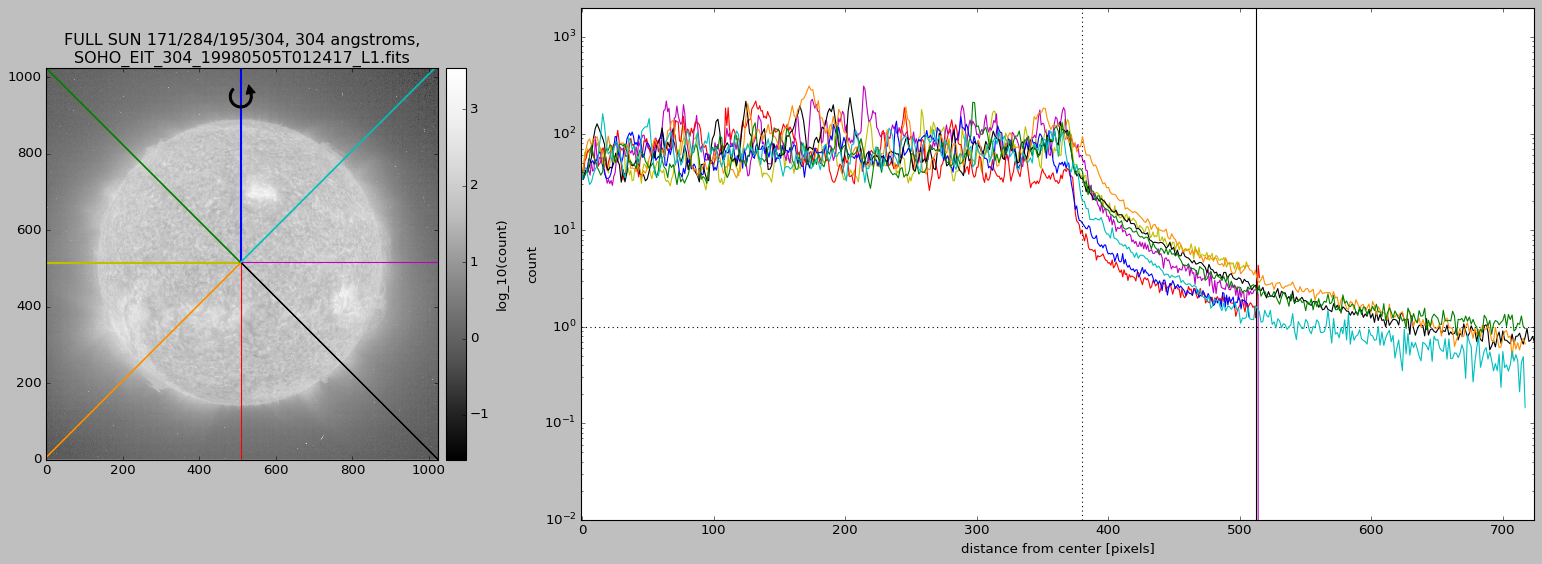

1998-05-05T01:00:26.514Z
171
no


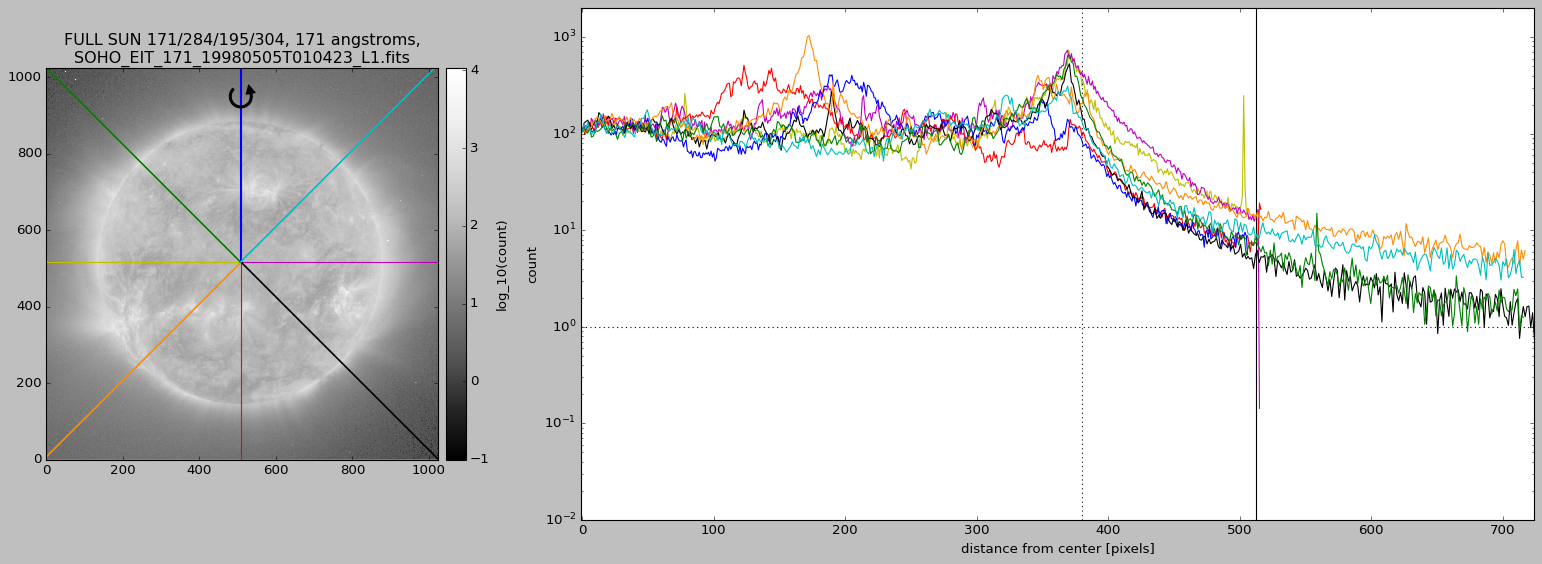

1998-05-05T07:09:11.637Z
284
no


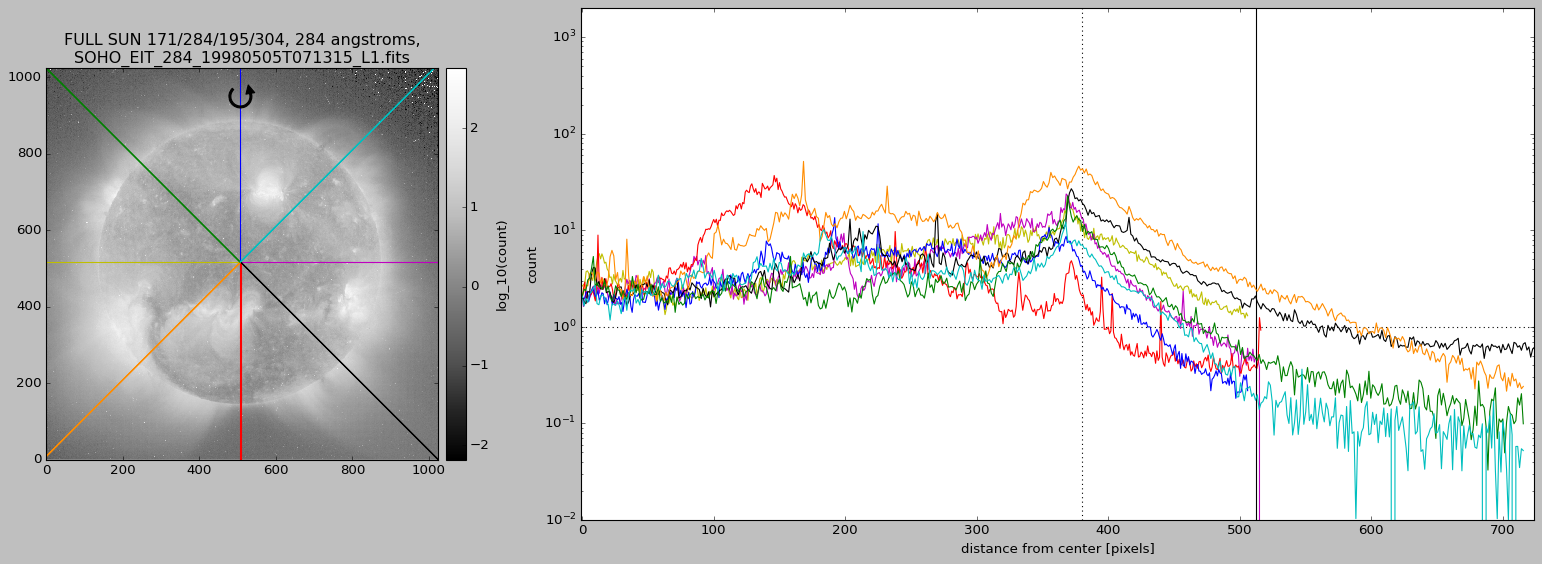

1998-05-05T19:02:45.097Z
195
yes


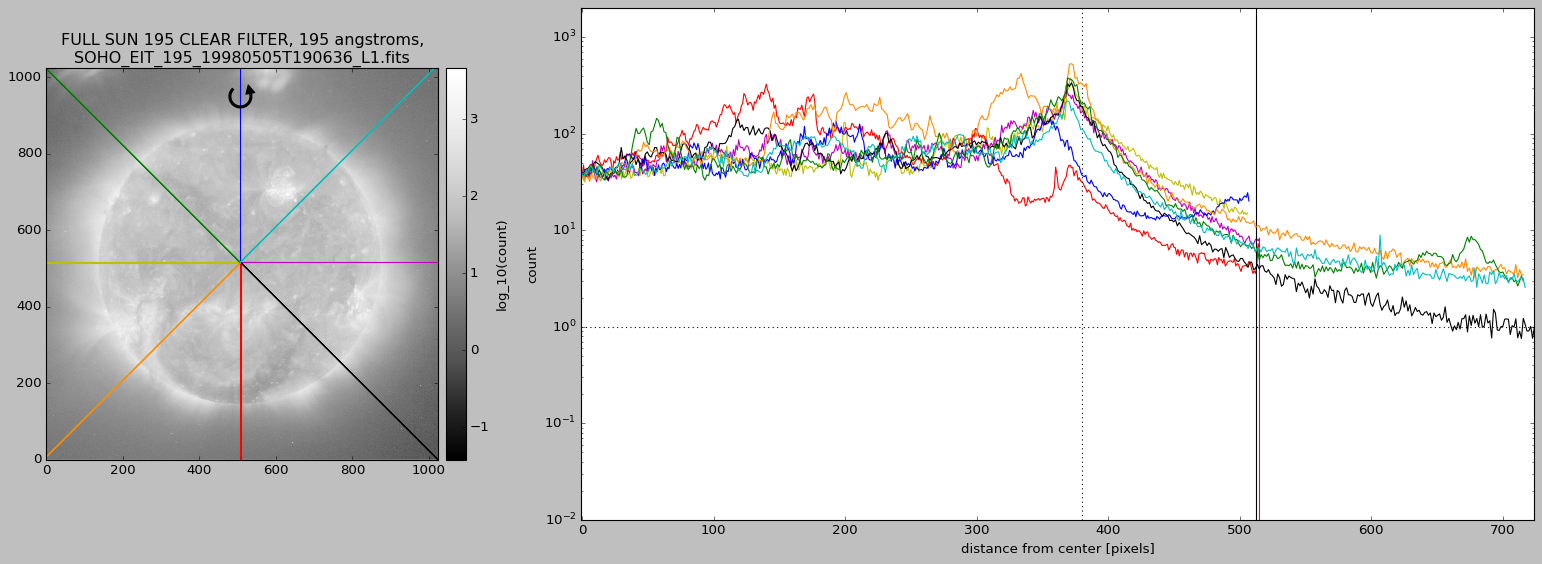

1998-05-05T19:14:30.725Z
171
yes


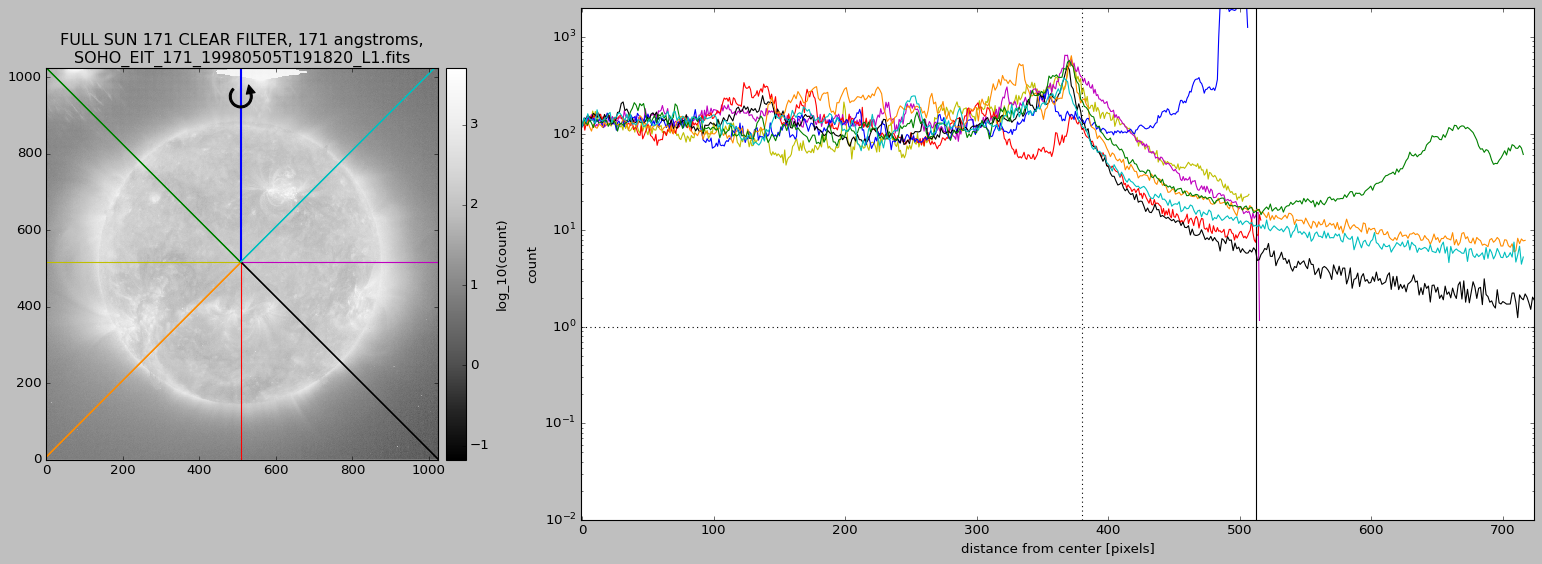

1998-05-05T01:06:17.959Z
284
yes


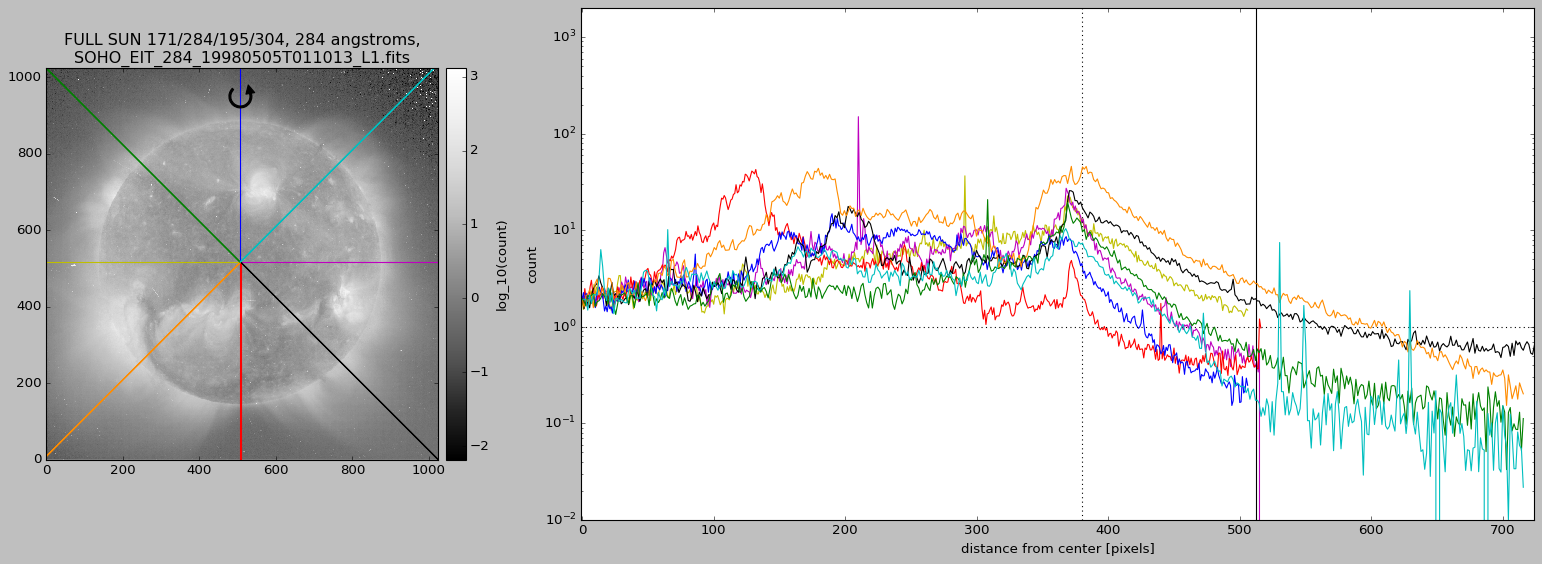

In [32]:
for f in os.scandir("./EIT/1998/05/05"):
    hdul = fits.open(f.path)
    header = hdul[0].header
    data = hdul[0].data

    #print(repr(header))
    sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()
    #print(sci_obj_)
    
    if "full_sun" in sci_obj_:
        #print(header['MSBLOCKS'])
        if np.shape(data) == (1024,1024) and header['MSBLOCKS'] == 0:
            print(header['DATE-BEG'])
            print(header['WAVELNTH'])
            print(header['CAMERERR'])
            #print("")
            #print(np.min(data))
            #print(len(np.ravel(data[data <= 0.])))
            # substitute nans for negative numbers
            data[data <= 0.] = 0.
            #print(data[data <= 0.])
            
            xcenter, ycenter = eit.center_from_header(header)
            xcenter = int(np.round(xcenter,0))
            ycenter = int(np.round(ycenter,0))

            obsdate = header['DATE-BEG'].split("T")[0]
            obstime = header['DATE-BEG'].split("T")[1].split("Z")[0]
            wavelength = header['WAVELNTH']

            if True: #wavelength==284:
                #eit.plot_full_sun_annuli_EIT(f.name, header, data, darkFlux=854.,figtitle=r"{0} $\AA$, {1} {2} UTC".format(wavelength, obsdate, obstime), xcenter=xcenter, ycenter=ycenter, maskBrightSpots=True)
                eit.plot_full_sun_EIT(f.name, header, data, xcenter=xcenter, ycenter=ycenter)
                
                """
                testF, testFunc = eit.image_to_LCpoint(data, xcenter=xcenter, ycenter=ycenter, maskBrightSpots=False)
                print(testF, testFunc)
                print('ratio is {0}'.format(testFunc/testF))
    
                testF, testFunc = eit.image_to_LCpoint(data, xcenter=xcenter, ycenter=ycenter, maskBrightSpots=True)
                print(testF, testFunc)
                print('ratio is {0}'.format(testFunc/testF))
                """
                '''
                rs, annNpixs, annNpixs_unc, annFluxes, annFluxes_unc = eit.flux_in_annuli(data, darkFlux=852., xcenter=xcenter, ycenter=ycenter, rExtrapolate=512)
    
                fig, axes = plt.subplots(2,1,figsize=(8,6))
                axes[0].errorbar(rs, annFluxes, yerr=annFluxes_unc, capsize=0.,elinewidth=1.,color='k',marker='.')
                axes[0].set_yscale("log")
                axes[1].plot(rs[0:-1], annFluxes[1:] - annFluxes[0:-1], 'k.')
                plt.show()
                
                #print(np.argmax(np.sum(data[913:],axis=0)))
                #print(np.argmax(np.sum(data[913:],axis=1)))
                print("here")
                sumOverRow = np.sum(data[931:],axis=0)
                sumOverCol = np.sum(data[931:],axis=1)

                print(np.argmax(sumOverRow))
                print(np.argmax(sumOverCol))
                
                fig, axes = plt.subplots(2,1,figsize=(8,6))
                axes[0].plot(np.arange(1024), sumOverRow, 'k.')
                axes[0].set_xlim(0,1024)
                #axes[0].set_ylim(0,100)
                #axes[0].axvline(557,color='r')
                #axes[0].axvline(557-40, color='r', ls=':')
                #axes[0].axvline(557+40, color='r', ls=':')

                #axes[0].axvline(93,color='r')
                #axes[0].axvline(93+150, color='r', ls=':')
                #axes[0].axvline(0, color='r', ls=':')
                
                axes[1].plot(np.arange(1024-931), sumOverCol, 'k.')
                axes[1].set_xlim(0,1024-931)
                
                #axes[1].set_ylim(0,1000)
                #axes[1].axvline(131,color='r')
                plt.show()
                '''

    #signal = np.sum(data)
    #noise = np.sqrt(np.sum(data) + 1024*1024*852.)
    #print("signal is {0}".format(signal))
    #print("sqrt(signal) is {0}".format(np.sqrt(signal)))
    #print("noise is {0}".format(noise))
    #print("SNR is {0}".format(signal/noise))

    
    hdul.close()
